In [1]:
import torch 
import pandas as pd 
import torch.nn as nn 
from torch.utils.data import random_split, DataLoader, TensorDataset 
import torch.nn.functional as F 
import numpy as np 
import torch.optim as optim 
from torch.optim import AdamW
import random
import matplotlib.pyplot as plt
import seaborn as sns

import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [2]:
def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

In [3]:
set_random_seed(42)

X = 3*(torch.rand(1000, 2)-0.5)

X

tensor([[ 1.1468,  1.2450],
        [-0.3514,  1.3779],
        [-0.3287,  0.3027],
        ...,
        [-1.4233, -0.7696],
        [-0.7177,  0.8503],
        [-0.9676, -0.1411]])

In [4]:
X_train = X[:900,:]
X_val = X[800:900,:]
X_test = X[900:,:]
X_train.shape

torch.Size([900, 2])

In [5]:
train_loader = DataLoader(X_train, batch_size = 40, shuffle = True) 
validate_loader = DataLoader(X_val, batch_size = 20) 
test_loader = DataLoader(X_test, batch_size = 1)

In [6]:
# Define model parameters 
input_size = list(X_train.shape)[1]   
output_size = 20



# Define neural network 
class Network(nn.Module): 
    def __init__(self, input_size, output_size, init_form="normal"): 
        super().__init__() 
        self.conv_stack = nn.Sequential(
        nn.Linear(input_size, 500), 
        nn.Tanh(),
        nn.Dropout(p=0.2),
        nn.Linear(500, 500),
        nn.Tanh(),
        nn.Dropout(p=0.2),
        nn.Linear(500, 500),
        nn.Tanh(),
        nn.Dropout(p=0.2),
        nn.Linear(500, output_size) )
        self.init_form = init_form
        if self.init_form is not None:
            self.init()

    def forward(self, x): 
        return self.conv_stack(x)
    
        # xavier weight initialization
    def init(self):
        sigmoid_gain = torch.nn.init.calculate_gain("tanh")
        for child in self.conv_stack.children():
            if isinstance(child, nn.Linear):
                if self.init_form == "normal":
                    torch.nn.init.xavier_normal_(child.weight,
                                                 gain=sigmoid_gain)
                    if child.bias is not None:
                        torch.nn.init.zeros_(child.bias)
                elif self.init_form == "uniform":
                    torch.nn.init.xavier_uniform_(child.weight,
                                                  gain=sigmoid_gain)
                    if child.bias is not None:
                        torch.nn.init.zeros_(child.bias)
                else:
                    raise NotImplementedError()

In [7]:
class least_action(nn.Module):
    
    def __init__(self):
        super(least_action, self).__init__()

    def forward(self, targets, outputs, func): 
        tmp = self.action(targets, outputs, func)
        loss =  torch.mean(tmp)
        
        return loss
    
    def action(self, t, num, func):
        dt = 0.2
        epsilon = 0
        loss1 = 0
        loss1 += torch.abs((t[:,0]+num[:,1]-2*num[:,0])/dt/dt + num[:,0])
        for i in range(num.shape[1]-2):
            loss1 += torch.abs((num[:,i]+num[:,i+2]-2*num[:,i+1])/dt/dt + num[:,i+1])
            
            
            
        loss1 += torch.abs((t[:,1]+num[:,-2]-2*num[:,-1])/dt/dt + num[:,-1]) 
        

            
        return loss1
    
    



In [8]:
def f(x):       
          
    return 0.5*torch.pow(x,2)



In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_epoch(model,
                optimizer,
                criterion,
                train_loader):
    loss_history = []
    for batch in train_loader: 
        optimizer.zero_grad()
        x_train = batch # parse data
        x_train= x_train.to(device) # compute on gpu
        y_pred = model(x_train) # get predictions
        loss = criterion(x_train, y_pred, f) # compute loss
        loss_history.append(loss.cpu().detach().numpy()) # write loss to log
        loss.backward()
        optimizer.step()
    return loss_history

In [10]:
def validate(model,
             criterion,
             val_loader):
    cumloss = 0
    loss_history = []
    with torch.no_grad():
        for batch in val_loader:
            x_train = batch # parse data
            x_train = x_train.to(device) # compute on gpu
            y_pred = model(x_train) # get predictions
            loss = criterion(x_train, y_pred, f) # compute loss
            loss_history.append(loss.cpu().detach().numpy()) # write loss to log
            cumloss += loss
    return cumloss / len(val_loader), loss_history # mean loss and history

In [11]:
from tqdm import tqdm

def train_model(model, optimizer, model_name=None, n_epochs=5):
  
    criterion = least_action().to(device)

    train_history = {}
    train_history['model_name'] = model_name
    train_history['loss_on_train'] = []
    train_history['loss_on_test'] = []

    for epoch in tqdm(range(n_epochs)):
        loss_on_train = train_epoch(model,
                                    optimizer,
                                    criterion,
                                    train_loader)
        _, loss_on_test = validate(model,
                                   criterion,
                                   validate_loader)
        train_history['loss_on_train'].append(np.mean(loss_on_train))
        train_history['loss_on_test'].append(np.mean(loss_on_test))
        scheduler.step()
    return train_history

In [12]:
def exponential_smoothing(scalars, weight):  
    last = scalars[0]  
    smoothed = []
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  
        smoothed.append(smoothed_val)                        
        last = smoothed_val                                 

    return smoothed


def plot_history(history, n_epochs=5, smooth_val=0.9):
    fig, ax =  plt.subplots(3, 1, figsize=(12, 14))
    for stage_idx, (stage_lbl, stage_title) in enumerate(
        zip(['loss_on_train', 'loss_on_test'],
            ['train loss', 'val loss'])):
        # plot history on each learning step
        epoch_len = len(history[stage_lbl])//n_epochs
        full_stage_len = len(history[stage_lbl])
        ax[stage_idx].plot(exponential_smoothing(history[stage_lbl], smooth_val),
                           label='smoothed',
                           color='m')
        ax[stage_idx].plot(history[stage_lbl],
                           label='raw',
                           alpha=0.2,
                           color='c')
        ax[stage_idx].set_title(stage_title)
        ax[stage_idx].set_xlabel('epochs')
        ax[stage_idx].set_ylabel('loss')
        epochs_ticks_positions = np.arange(stop=full_stage_len+1,
                                           step=epoch_len)
        ax[stage_idx].set_xticks(np.arange(0,1000,100))
        ax[stage_idx].set_xticklabels(np.arange(0,1000,100))
        ax[stage_idx].legend()

        # plot mean train and test loss combined
        mean_loss_on_epoch = [np.mean(history[stage_lbl][i:i+epoch_len]) \
                              for i in range(0, full_stage_len, epoch_len)]
        std_loss_on_epoch = [np.std(history[stage_lbl][i:i+epoch_len]) \
                              for i in range(0, full_stage_len, epoch_len)]

        ax[2].set_title('\nAverage loss per epoch')
        ax[2].errorbar(np.arange(n_epochs) + stage_idx / 30.,
                       mean_loss_on_epoch,
                       yerr=std_loss_on_epoch,
                       capsize=5,
                       fmt="X--",
                       label=stage_title)
        ax[2].set_xticks(np.arange(0,1000,100))
        ax[2].set_xticklabels(np.arange(0,1000,100))
        ax[2].set_xlabel('epochs')
        ax[2].set_ylabel('loss')
        ax[2].legend()

    fig.suptitle(history['model_name'], fontsize=24)
    plt.show()

In [13]:
set_random_seed(42)

model = Network(input_size,output_size).to(device) 
optimizer = optim.AdamW(model.parameters(),  betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01,  lr=1e-3)

lambda1 = lambda epoch: 0.998 ** epoch
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1, last_epoch = -1)

n_epochs = 300
history = train_model(model, optimizer, model_name='model', n_epochs=n_epochs)

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [01:27<00:00,  3.41it/s]


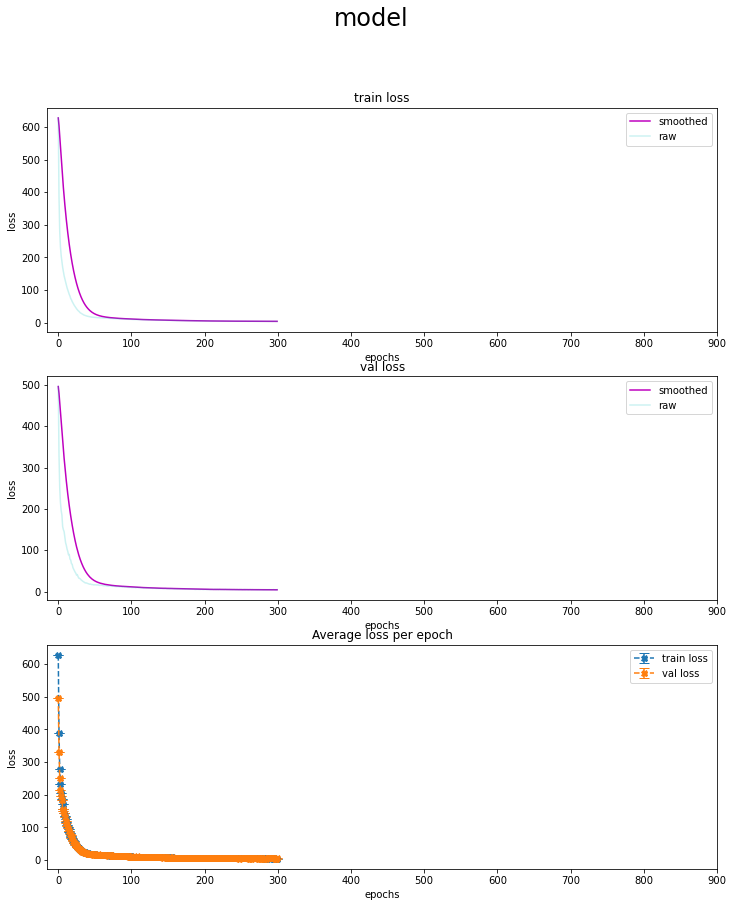

In [14]:
plot_history(history, n_epochs=n_epochs)

In [15]:
model.eval()

Network(
  (conv_stack): Sequential(
    (0): Linear(in_features=2, out_features=500, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=500, out_features=500, bias=True)
    (4): Tanh()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=500, out_features=500, bias=True)
    (7): Tanh()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=500, out_features=20, bias=True)
  )
)

In [16]:
a = X[1,:]
print(a, model(a.to(device)))

tensor([-0.3514,  1.3779]) tensor([-0.6369, -0.8482, -1.0287, -1.1682, -1.2604, -1.3031, -1.2923, -1.2332,
        -1.1246, -0.9719, -0.7772, -0.5563, -0.3046, -0.0437,  0.2199,  0.4741,
         0.7116,  0.9205,  1.0939,  1.2239], device='cuda:0',
       grad_fn=<AddBackward0>)


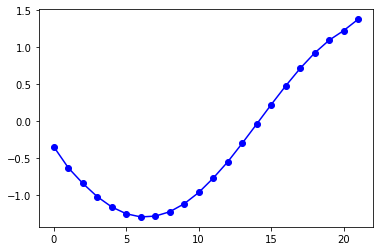

In [17]:
import numpy as np 
from matplotlib import pyplot as plt 

plt.plot(np.append(a.numpy()[0],np.append(model(a.to(device)).cpu().detach().numpy(), a.numpy()[1])), marker='o', color='b', label='line with marker')

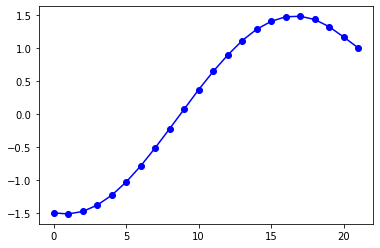

In [18]:
b = torch.tensor([-1.5,  1.])
plt.plot(np.append(b.numpy()[0],np.append(model(b.to(device)).cpu().detach().numpy(), b.numpy()[1])), marker='o', color='b', label='line with marker')

In [19]:
def classic(i,f,dt,t):
    return i*np.sin(dt*20-t)/np.sin(20*dt) + f*np.sin(t)/np.sin(20*dt)

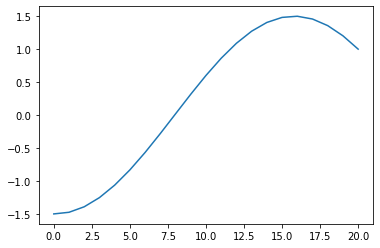

In [20]:
a = []
dt = 0.2
for i in range(21):
    a.append(classic(b[0],b[1],dt,i*dt))
plt.plot(a)

## Try to make many random paths

In [21]:
# Network hyperparameters
latent_size = 128
Nin = list(X_train.shape)[1] +  latent_size   # Inputs to the neural network
Nout = 20  # Outputs of the neural network
Nhid = 100  # Nodes in the hidden layer

W1 = torch.randn(Nhid, Nin, requires_grad=True)  # First set of coefficients
B = torch.rand(Nhid, requires_grad=True) * 2. - 1.    # Set of bias parameters
W2 = torch.randn(Nout, Nhid, requires_grad=True)        # Second set of coefficients

# Define neural network 
class Network2(nn.Module): 
    def __init__(self, input_size, output_size, init_form="normal"): 
        super().__init__() 
        # We set the operators 
        self.lc1 = nn.Linear(in_features=Nin, 
                             out_features=Nhid, 
                             bias=True)   # shape = (Nhid, Nin)
        self.actfun = nn.Sigmoid()        # activation function
        self.lc2 = nn.Linear(in_features=Nhid, 
                             out_features=Nout, 
                             bias=False)  # shape = (Nout, Nhid)
        
        # We set the parameters 
        with torch.no_grad():
            self.lc1.weight = nn.Parameter(W1)
            self.lc1.bias = nn.Parameter(B)
            self.lc2.weight = nn.Parameter(W2)
   
    # We set the architecture
    def forward(self, x): 
        o = self.lc2(self.actfun(self.lc1(x)))
        return o

In [22]:
class least_action2(nn.Module):
    
    def __init__(self):
        super(least_action2, self).__init__()

    def forward(self, targets, outputs, func): 
        tmp = self.action(targets, outputs, func)
        loss =  torch.mean(tmp)
        
        return loss
    
    def action(self, t, num, func):
        dt = 0.2
        epsilon = 0
        loss1 = 0
        loss1 += torch.abs((t[:,0]+num[:,1]-2*num[:,0])/dt/dt + num[:,0])
        for i in range(num.shape[1]-2):
            loss1 += torch.abs((num[:,i]+num[:,i+2]-2*num[:,i+1])/dt/dt + num[:,i+1])
            
            
            
        loss1 += torch.abs((t[:,1]+num[:,-2]-2*num[:,-1])/dt/dt + num[:,-1]) 
        

            
        return loss1
    

In [23]:
from tqdm import tqdm

def train_epoch(model,
                optimizer,
                criterion,
                train_loader):
    loss_history = []
    for batch in train_loader: 
        optimizer.zero_grad()
        x_train = batch # parse data
        x_train2 = torch.randn((x_train.shape[0],latent_size))
        x_train = torch.cat((x_train,x_train2),1)
        x_train= x_train.to(device) # compute on gpu
        y_pred = model(x_train) # get predictions
        loss = criterion(x_train, y_pred, f) # compute loss
        loss_history.append(loss.cpu().detach().numpy()) # write loss to log
        loss.backward()
        optimizer.step()
    return loss_history

In [24]:
def validate(model,
             criterion,
             val_loader):
    cumloss = 0
    loss_history = []
    with torch.no_grad():
        for batch in val_loader:
            x_train = batch # parse data
            x_train2 = torch.randn((x_train.shape[0],latent_size))
            x_train = torch.cat((x_train,x_train2),1)
            x_train = x_train.to(device) # compute on gpu
            y_pred = model(x_train) # get predictions
            loss = criterion(x_train, y_pred, f) # compute loss
            loss_history.append(loss.cpu().detach().numpy()) # write loss to log
            cumloss += loss
    return cumloss / len(val_loader), loss_history # mean loss and history

In [25]:
def train_model(model, optimizer, model_name=None, n_epochs=5):
  
    criterion = least_action2().to(device)

    train_history = {}
    train_history['model_name'] = model_name
    train_history['loss_on_train'] = []
    train_history['loss_on_test'] = []

    for epoch in tqdm(range(n_epochs)):
        loss_on_train = train_epoch(model,
                                    optimizer,
                                    criterion,
                                    train_loader)
        _, loss_on_test = validate(model,
                                   criterion,
                                   validate_loader)
        train_history['loss_on_train'].append(np.mean(loss_on_train))
        train_history['loss_on_test'].append(np.mean(loss_on_test))
        scheduler.step()
    return train_history

In [26]:
set_random_seed(0)
# seed=0
model2 = Network2(input_size,output_size).to(device) 
optimizer = optim.AdamW(model2.parameters(), lr=0.001)

lambda1 = lambda epoch: 0.998 ** epoch
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1, last_epoch = -1)

n_epochs = 5

history = train_model(model2, optimizer, model_name='model', n_epochs=n_epochs)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.00it/s]


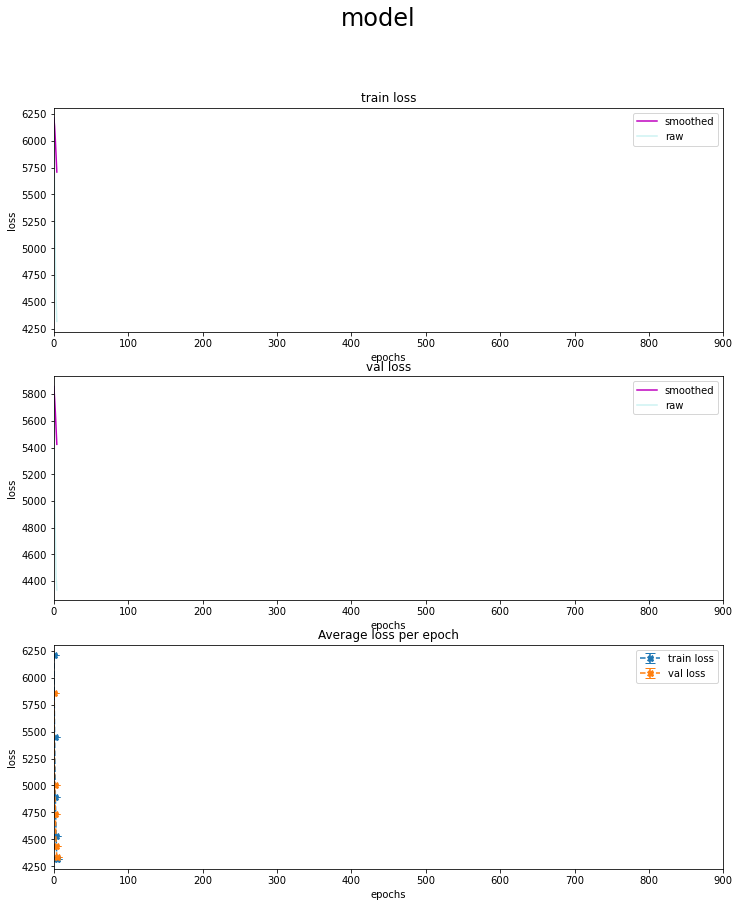

In [27]:
plot_history(history, n_epochs=n_epochs)

In [28]:
model2.eval()

Network2(
  (lc1): Linear(in_features=130, out_features=100, bias=True)
  (actfun): Sigmoid()
  (lc2): Linear(in_features=100, out_features=20, bias=False)
)

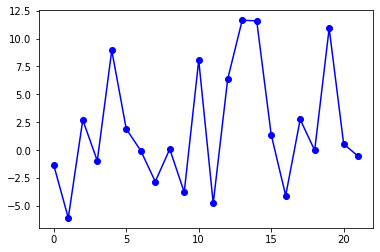

In [29]:
a = X[100,:]
a = torch.cat((a,torch.randn(128,1).reshape(-1)),0)
plt.plot(np.append(a.numpy()[0],np.append(model2(a.to(device)).cpu().detach().numpy(), a.numpy()[1])), marker='o', color='b', label='line with marker')

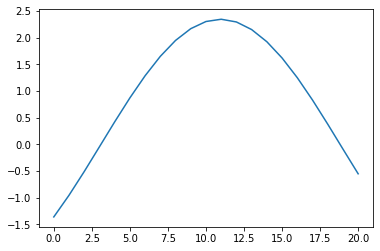

In [30]:
a1 = []
dt = 0.2
for i in range(21):
    a1.append(classic(a[0],a[1],dt,i*dt))
plt.plot(a1)

In [31]:
def actionE(t, num, func):
    dt = 0.2
    loss1 = 0
    loss1 += 0.5*(t[0]-num[0])*(t[0]-num[0])/dt + func(t[0])*0.5*dt
    for i in range(num.shape[0]-1):
        loss1 += 0.5*(num[i]-num[i+1])*(num[i]-num[i+1])/dt + func(num[i])*dt
            
    loss1 += 0.5*(t[1]-num[-1])*(t[1]-num[-1])/dt + func(num[-1])*dt + func(t[1])*dt*0.5
    return loss1

In [32]:
a = X[10,:]
a2 = torch.cat((a,torch.randn(128,1).reshape(-1)),0)
actionE(a,model2(a2.to(device)).cpu().detach(),f)

tensor(2392.7607)

In [33]:
A = 0
for i in range(1000):
    a = X[8,:]
    a2 = torch.cat((a,torch.randn(128,1).reshape(-1)),0)
    S = actionE(a,model2(a2.to(device)).cpu().detach(),f)
    A += np.exp(-S)

In [34]:
np.absolute(A)

tensor(0.)

In [35]:
actionE(a,model(a.to(device)).cpu().detach(),f)

tensor(4.0446)

In [36]:
np.sqrt((1/3.14/np.sinh(4.2))*(np.cosh(4.2)-1))*np.exp(-1/2*((a[0]**2+a[1]**2)*np.cosh(4.2)-2*a[0]*a[1])/np.sinh(4.2))

tensor(0.2800)

In [37]:
h_bar = 1 #constant of nature, set to 1 for convenience 

def V(q,m=1,omega=1):
    return 0.5 * m * (omega**2) * (q**2)

def dV(q,m=1,omega=1):
    return m * (omega**2) * q

def Phi(q,m=1,omega=1):
    N = np.size(q)
    term = V(q,m,omega) + (0.5 * q * dV(q,m,omega))
    return np.sum(term)/N

def U(q,beta=1,m=1,omega=1):
    N = np.size(q)
    term = np.zeros(N)

    for i in range(N-1):
        term[i] = (m*(q[i+1]-q[i])**2)/(2*(beta/N)*(h_bar**2)) + (beta/N)*V(q[i])  

    term[N-1] = (m*(q[0]-q[N-1])**2)/(2*(beta/N)*(h_bar**2)) + (beta/N)*V(q[i])

    return np.sum(term)

def prob(U):
    return np.exp(-U)

def exact_H(beta,omega=1):
    return (h_bar * omega) * (0.5 + (np.exp(beta*h_bar*omega)-1)**-1)

In [38]:
num_steps = 1000
m = 1
omega = 1
H_avg = np.zeros(num_steps)
Z = np.zeros(num_steps)
a = X[0,:]
a2 = torch.cat((a,torch.randn(128,1).reshape(-1)),0)
q = model2(a2.to(device)).cpu().detach().numpy()
H_avg[0] = Phi(q,m=1,omega=1)*prob(U(q))
Z[0] = prob(U(q))
qq = np.array([])

for i in range(num_steps-1):
    a = torch.tensor([0.,0.])
    a2 = torch.cat((a,torch.randn(128,1).reshape(-1)),0)
    q = model2(a2.to(device)).cpu().detach().numpy()
    H_avg[i+1] = Phi(q,m=1,omega=1)*prob(U(q))
    Z[i+1] = prob(U(q))
    qq = np.append(qq,q)


np.sum(H_avg)/np.sum(Z)

C:\Users\user\AppData\Local\Temp\ipykernel_17052\3208302216.py:22: RuntimeWarning: invalid value encountered in double_scalars
  np.sum(H_avg)/np.sum(Z)


nan

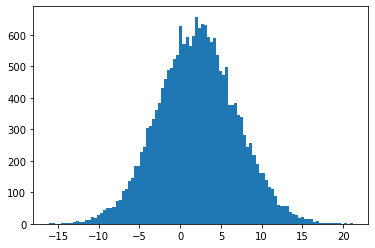

In [39]:
_ = plt.hist(qq, bins=100)
plt.show()

In [40]:
np.sum(qq**2)/qq.shape[0]

27.68226559153575